<center> <h1> <b> Исследование автоэнкодера </b> </h1> </center>

In [ ]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=2b57d7289c2a39c406ebba9188128b4ad13ac2aaa9e29c355885d2deb021b5ce
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


In [ ]:
import os
import cv2
import torch
import idx2numpy
import numpy as np
from torch import nn
from torch.optim import SGD
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn.modules.activation import ReLU
from torchvision.datasets import FashionMNIST
from torch.utils.data.dataset import TensorDataset

In [ ]:
if not os.path.exists('/content/FashionMNIST/raw'):
    FashionMNIST(root='/content', download=True)
!rm /content/FashionMNIST/raw/*.gz
# train-images-idx3-ubyte -- X_train
# train-labels-idx1-ubyte -- y_train
# t10k-images-idx3-ubyte  -- X_valid
# t10k-labels-idx1-ubyte  -- y_valid
y_train_np = idx2numpy.convert_from_file('/content/FashionMNIST/raw/train-images-idx3-ubyte')
y_valid_np = idx2numpy.convert_from_file('/content/FashionMNIST/raw/t10k-images-idx3-ubyte')
y_train_np = y_train_np.copy()
y_valid_np = y_valid_np.copy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



<center> <h3> Формирование зашумленных изображений </h3> </center>

In [ ]:
def add_noise(data):
    for i in range(data.shape[0]):
        n = cv2.randn(np.zeros(data.shape[1:3], dtype=np.uint8), 0, 120)
        data[i] = data[i] + n
    return data
X_train_np = add_noise(y_train_np.copy())
X_valid_np = add_noise(y_valid_np.copy())
print(f'mean X_train: {np.round(np.mean(X_train_np), 3)}, std X_train: {np.round(np.std(X_train_np), 3)}')

mean X_train: 91.639, std X_train: 84.734


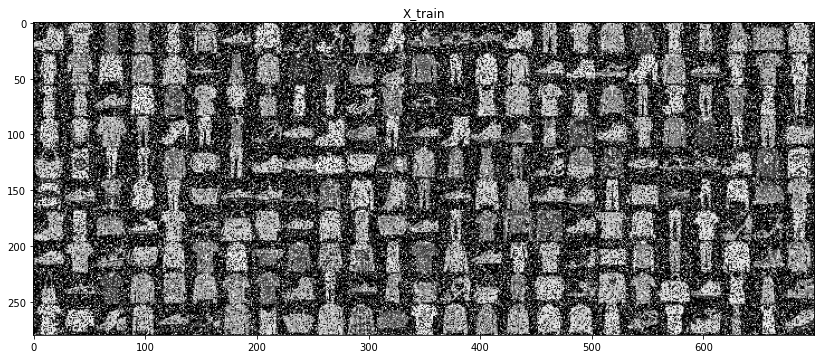

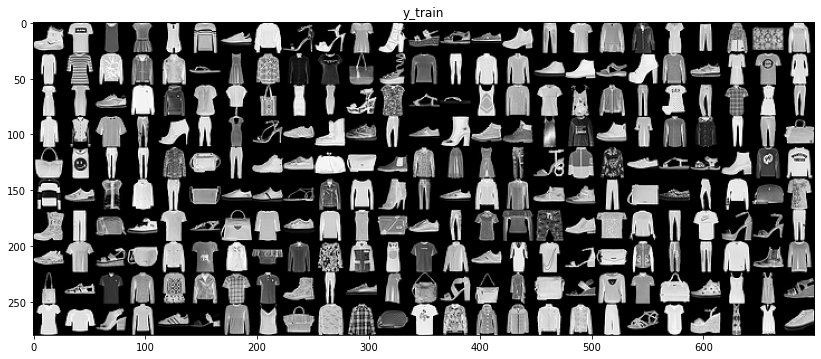

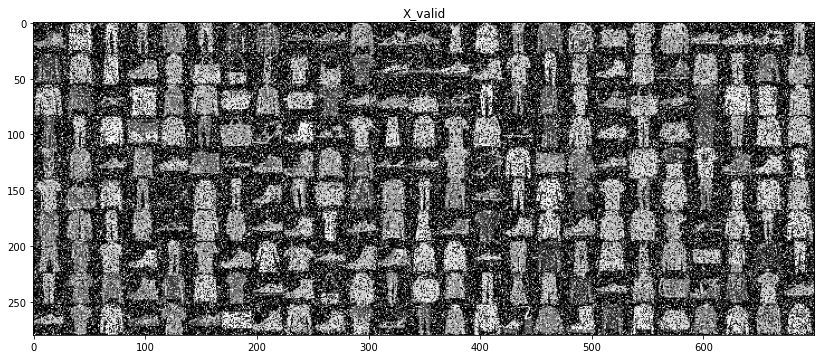

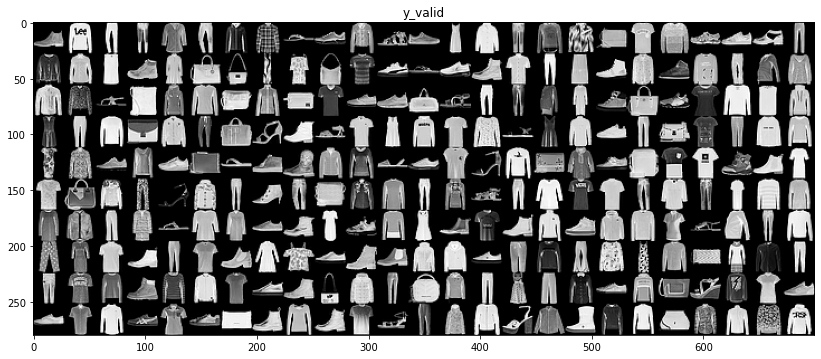

In [ ]:
def check_data(data, name):
    n, m = 10, 25
    img = np.zeros((28 * n, 28 * m))
    x = iter(data)
    for i, j in product(range(n), range(m)):
        img[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = next(x)
    plt.figure(figsize=(14, 10))
    plt.title(name)
    plt.imshow(img, 'gray')
    plt.show()
check_data(X_train_np, 'X_train')
check_data(y_train_np, 'y_train')
check_data(X_valid_np, 'X_valid')
check_data(y_valid_np, 'y_valid')


In [ ]:
from torchvision.transforms.functional import convert_image_dtype
class DataFormer(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.transform = transform
        self.X = X
        self.y = y

    def __getitem__(self, index):
        X, y = self.X[index], self.y[index]
        return self.transform(X / 255), torch.FloatTensor(y).unsqueeze(0) / 255
    
    def __len__(self):
        return len(self.X)

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.ConvertImageDtype(torch.float)
                                
])
train_dataset = DataFormer(X_train_np, y_train_np, transform)
valid_dataset = DataFormer(X_valid_np, y_valid_np, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, shuffle=False)
for X, y in train_loader:
    print(X.size(), y.size())
    print(torch.max(X), torch.max(y))
    break

torch.Size([32, 1, 28, 28]) torch.Size([32, 1, 28, 28])
tensor(1.) tensor(1.)


<center> <h3> Подготовка модели </h3> </center>

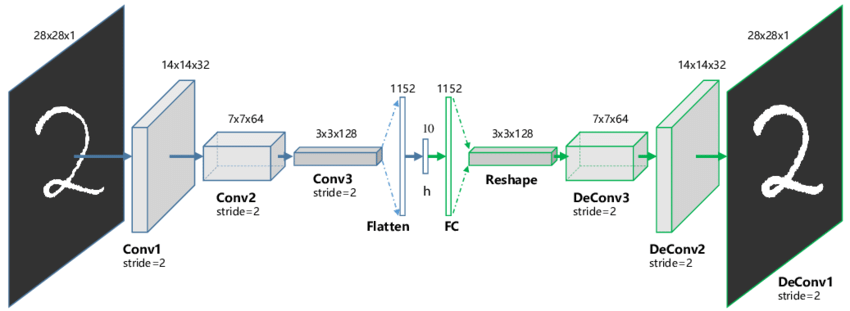

In [ ]:
# Encoder
#0) (1, 28, 28)
#1) (32, 28, 28) conv2d
#2) (32, 14, 14) ReLU
#3) (32, 14, 14) maxpool (2, 2)

#4) (64, 14, 14) conv2d
#5) (64, 14, 14) ReLU
#6) (64, 7, 7) maxpool (2, 2)

#7) (128, 6, 6) conv2d
#8) (128, 6, 6) ReLU
#9) (128, 3, 3) maxpool (2, 2)

# Fully connected

#10) (1152, 1, 1) FLatten
#11) (10, 1, 1) Linear
#11) (10, 1, 1) Relu
#12) (1152, 1, 1) Relu

#13) (128, 3, 3) Reshape

# decoder

#12) (64, 7, 7) ConvTranspose2d
#13) (64, 7, 7) ReLU

#14) (32, 14, 14) ConvTranspose2d
#15) (32, 7, 7) ReLU

#16) (1, 28, 28) ConvTranspose2d
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(2, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)) 
            

        )

        self.fully_connected = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(1152, 64),
            nn.ReLU(),
            nn.Linear(64, 1152),
            nn.ReLU(),
            #x.view(-1, 128, 3, 3)

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=2),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4, 4), stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(4, 4), stride=2, padding=1)

        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.fully_connected(x)
        x = x.view(-1, 128, 3, 3)
        x = self.decoder(x)
        return x
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Устройство: {device}')
model = ConvAutoencoder()
model.to(device)

Устройство: cuda


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1152, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), pa

<center> <h3> Обучение </h3> </center>

In [ ]:
train_loss_list, valid_loss_list = [], []
train_mean_loss_list, valid_mean_loss_list = [], []

In [ ]:
model.train()
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9999)
criterion = nn.MSELoss()
epochs = 10
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    train = iter(train_loader)
    valid = iter(valid_loader)
    train_temp_mean_loss_list, valid_temp_mean_loss_list = [], []
    for i in tqdm(range(len(train_loader))):                   
        optimizer.zero_grad()
        X, y = next(train) 
    # Forward
        X, y = X.to(device), y.to(device)
        
        
        y_pred = model.forward(X)
    # Calculate loss
        loss = criterion(y_pred, y)

    # Backward
        loss.backward()

    # optimizer
        optimizer.step()


    # validate
        X_valid, y_valid = next(valid)
        X_valid, y_valid = X_valid.to(device), y_valid.to(device)
        y_valid_pred = model.forward(X_valid)
        valid_loss = criterion(y_valid_pred, y_valid)

    # metrics
        train_loss_list.append(loss.item())
        train_temp_mean_loss_list.append(loss.item())

        valid_loss_list.append(valid_loss.item())
        valid_temp_mean_loss_list.append(valid_loss.item())

    # metrics per epoch
    train_mean_loss_list.append(sum(train_temp_mean_loss_list) / len(train_temp_mean_loss_list))
    valid_mean_loss_list.append(sum(valid_temp_mean_loss_list) / len(valid_temp_mean_loss_list))
    torch.cuda.empty_cache()
    print(f'epoch: {epoch + 1}   '
          f'mean train loss per epoch: {sum(train_temp_mean_loss_list) / len(train_temp_mean_loss_list)}   '
          f'mean valid loss per epoch: {sum(valid_temp_mean_loss_list) / len(valid_temp_mean_loss_list)}   ')

<center> <h3> Визуализация результатов </h3> </center>

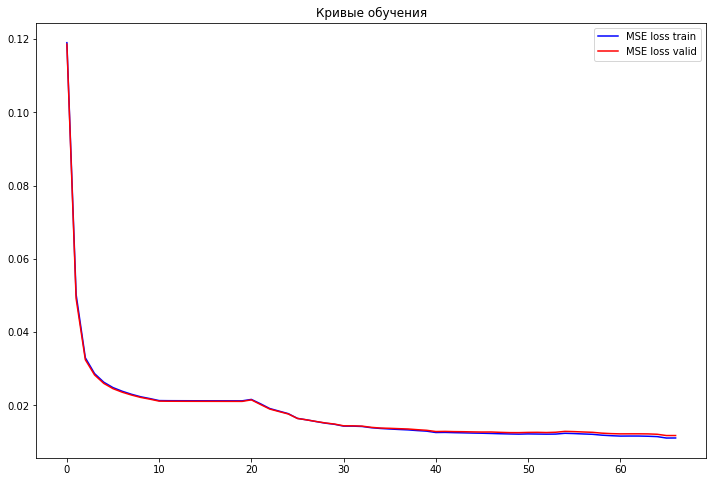

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_mean_loss_list, c='b')
plt.title('Кривые обучения')
plt.plot(valid_mean_loss_list, c='r')
plt.legend(['MSE loss train', 'MSE loss valid'])
plt.show()
# Ушел в магаз. надо было остановиться между (40-50) эпохами

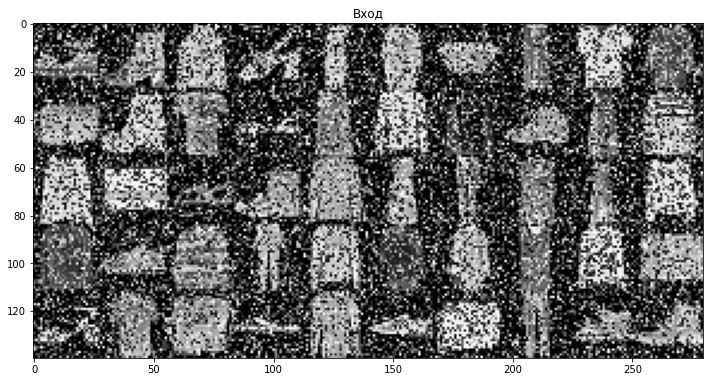

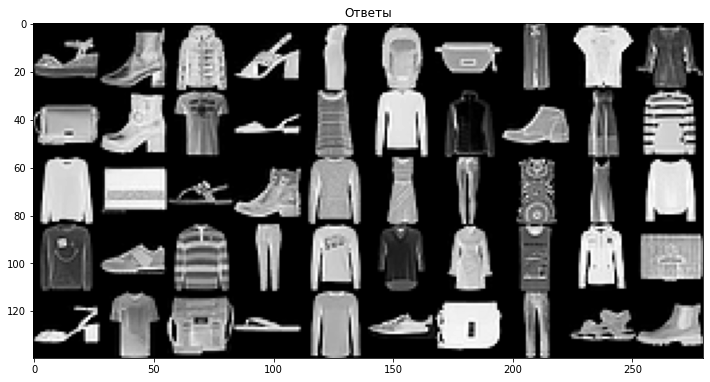

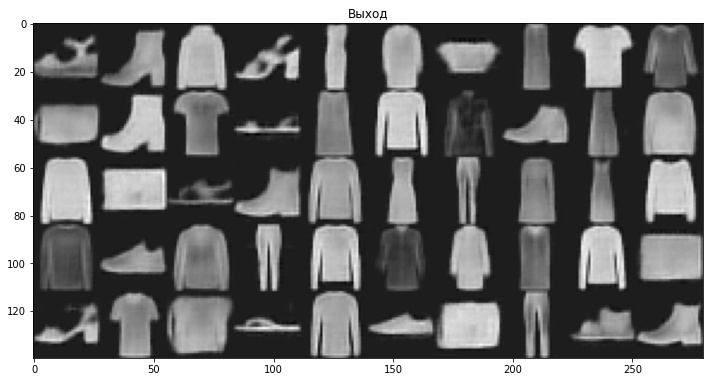

In [ ]:
model.eval()
n, m = 5, 10

inputs = np.zeros((n * 28, m * 28))
outputs = inputs.copy()
real = inputs.copy()


test_data = iter(valid)
with torch.no_grad():
    for i, j in product(range(n), range(m)): # Надо, конечно, на тестовой, а не на валидационной
        X, y = next(test_data)
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        inputs[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = X.squeeze().cpu().numpy()
        outputs[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = y_pred.squeeze().cpu().numpy()
        real[i * 28 : (i + 1) * 28, j * 28 : (j + 1) * 28] = y.squeeze().cpu().numpy()


plt.figure(figsize=(12, 8))
plt.imshow(inputs * 255, 'gray')
plt.title('Вход')
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(real * 255, 'gray')
plt.title('Ответы')
plt.show()

plt.figure(figsize=(12, 8))
plt.imshow(outputs * 255, 'gray')
plt.title('Выход')
plt.show()

Скорее надо увеличить число признаков пропускаемых боттлнеком